In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [4]:
def create_base_wafer(size=26):
    wafer=np.ones((size,size),dtype=int)
    #center
    cx,cy=size//2,size//2
    radius=size//2
    #now outside wafer we have to make it 0
    for i in range(size):
        for j in range(size):
            if (i-cx)**2 +(j-cy)**2 >radius**2:
                wafer[i,j]=0
    return wafer


In [5]:
def add_center_defect(wafer,c_radius=2,drop_prob=0.3,noise_prob=0.02):
    wafer=wafer.copy()
    size0=wafer.shape[0]
    size1=wafer.shape[1]
    cx,cy=size0//2,size1//2

    for i in range(size0):
        for j in range(size1):
            if (i-cx)**2 +(j-cy)**2 <=c_radius**2:
                if np.random.rand()>drop_prob:
                    wafer[i][j]=2

    #background noise
    mask=np.random.rand(*wafer.shape)<noise_prob
    wafer[mask&(wafer==1)]=2

    return wafer



def add_edge_ring_defect(wafer,thickness=2,drop_prob=0.42,noise_prob=0.02):
    wafer=wafer.copy()
    size0=wafer.shape[0]
    size1=wafer.shape[1]
    cx,cy=size0//2,size1//2
    r=size0//2

    for i in range(size0):
        for j in range(size1):
            dist=np.sqrt((i-cx)**2 +(j-cy)**2)
            if r-thickness<dist<r:
                if np.random.rand()>drop_prob:
                    wafer[i][j]=2

    #background noise
    mask=np.random.rand(*wafer.shape)<noise_prob
    wafer[mask&(wafer==1)]=2

    return wafer


def add_donut_defect(wafer,c_radius=2,thickness=2,drop_prob=0.35,noise_prob=0.02):
    wafer=wafer.copy()
    size0=wafer.shape[0]
    size1=wafer.shape[1]
    cx,cy=size0//2,size1//2
    r=size0//2

    for i in range(size0):
        for j in range(size1):
            dist=np.sqrt((i-cx)**2 +(j-cy)**2)

            #center region
            if (i-cx)**2 +(j-cy)**2 <=c_radius**2:
                if np.random.rand()>drop_prob:
                    wafer[i][j]=2

            #edge region
            if r-thickness<dist<r:
                if np.random.rand()>drop_prob:
                    wafer[i][j]=2

    #background noise
    mask=np.random.rand(*wafer.shape)<noise_prob
    wafer[mask&(wafer==1)]=2

    return wafer


def add_scratch_defect(wafer,drop_prob=0.3,noise_prob=0.02):
    wafer=wafer.copy()
    size=wafer.shape[0]
    x0=random.randint(0,size-1)

    for i in range(size):
        j=x0+i//2
        if 0<=j<size and wafer[i][j]==1:
            if np.random.rand()>drop_prob:
                wafer[i][j]=2

    #background noise
    mask=np.random.rand(*wafer.shape)<noise_prob
    wafer[mask&(wafer==1)]=2
    return wafer


def add_random_defect(wafer,prob=0.05):
    wafer=wafer.copy()
    mask=np.random.rand(*wafer.shape)<prob     #masking the wafer
    wafer[mask&(wafer==1)]=2          #marking the random points defected
    return wafer


def add_edge_loc_defect(wafer,radius=3,drop_prob=0.3,noise_prob=0.04):
    wafer=wafer.copy()
    size0=wafer.shape[0]
    size1=wafer.shape[1]

    #choose a random edge point
    edge_points=[
        (random.randint(0,size0-1),0),
        (random.randint(0,size0-1),size1-1),
        (0,random.randint(0,size1-1)),
        (size0-1,random.randint(0,size1-1))
    ]
    cx,cy=random.choice(edge_points)

    for i in range(size0):
        for j in range(size1):
            if (i-cx)**2 +(j-cy)**2 <=radius**2 and wafer[i][j]==1:
                if np.random.rand()>drop_prob:
                    wafer[i][j]=2

    #background noise
    mask=np.random.rand(*wafer.shape)<noise_prob
    wafer[mask&(wafer==1)]=2
    return wafer


def add_loc_defect(wafer,radius=3,drop_prob=0.3,noise_prob=0.02):
    wafer=wafer.copy()
    size0=wafer.shape[0]
    size1=wafer.shape[1]

    cx=random.randint(radius,size0-radius-1)
    cy=random.randint(radius,size1-radius-1)

    for i in range(size0):
        for j in range(size1):
            if (i-cx)**2 +(j-cy)**2 <=radius**2:
                if np.random.rand()>drop_prob:
                    wafer[i][j]=2

    #background noise
    mask=np.random.rand(*wafer.shape)<noise_prob
    wafer[mask&(wafer==1)]=2

    return wafer

def add_near_full_defect(wafer,prob=0.6,drop_prob=0.15):
    wafer=wafer.copy()

    #dense defects
    mask=np.random.rand(*wafer.shape)<prob
    wafer[mask&(wafer==1)]=2

    #drop some defects to create holes
    drop_mask=np.random.rand(*wafer.shape)<drop_prob
    wafer[drop_mask&(wafer==2)]=1

    return wafer

def add_none_defect(wafer,noise_prob=0.008):
    wafer=wafer.copy()

    #very sparse random noise
    mask=np.random.rand(*wafer.shape)<noise_prob
    wafer[mask&(wafer==1)]=2

    return wafer




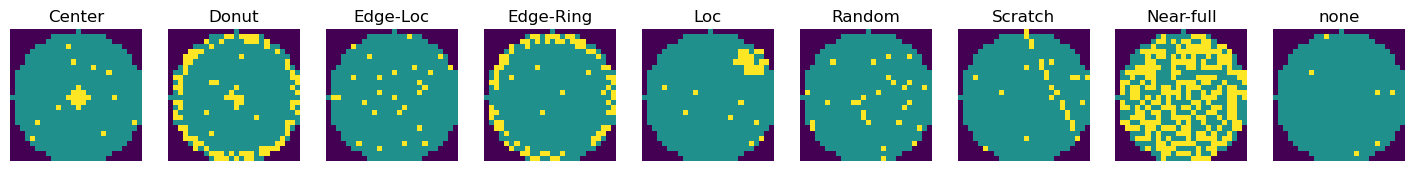

In [6]:
fig,ax=plt.subplots(1,9,figsize=(18,4))
funcs=[
    add_center_defect,
    add_donut_defect,
    add_edge_loc_defect,
    add_edge_ring_defect,
    add_loc_defect,
    add_random_defect,
    add_scratch_defect,
    add_near_full_defect,
    add_none_defect
]

names=["Center","Donut","Edge-Loc","Edge-Ring","Loc","Random","Scratch","Near-full","none"]

for i,f in enumerate(funcs):
    wafer=f(create_base_wafer())
    ax[i].imshow(wafer,cmap="viridis")
    ax[i].set_title(names[i])
    ax[i].axis("off")

plt.show()


In [7]:

class SyntheticWaferDataset(Dataset):
    def __init__(self, size=26):
        self.size=size
        self.defect_fns=[
            add_center_defect,
            add_donut_defect,
            add_edge_loc_defect,
            add_edge_ring_defect,
            add_loc_defect,
            add_random_defect,
            add_scratch_defect,
            add_near_full_defect,
            add_none_defect
        ]

    def __len__(self):
        return 10**9     #dummy large number (infinite stream)

    def __getitem__(self, idx):
        base=create_base_wafer(self.size)
        label=random.randint(0,len(self.defect_fns)-1)
        wafer=self.defect_fns[label](base)

        #one-hot encoding(0,1,2)
        wafer=np.eye(3)[wafer]
        wafer=wafer.transpose(2,0,1).astype(np.float32)
        return torch.tensor(wafer), torch.tensor(label)


In [8]:
synthetic_ds=SyntheticWaferDataset(size=26)
train_loader=DataLoader(
    synthetic_ds,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [9]:
class WaferCNN(nn.Module):
    def __init__(self,num_classes):
        super(WaferCNN,self).__init__()

        self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(64*6*6,128)
        self.fc2=nn.Linear(128,num_classes)

    def forward(self,x):
        x=self.pool(func.relu(self.conv1(x)))
        x=self.pool(func.relu(self.conv2(x)))
        x=x.view(x.size(0),-1)      #flattens the 2d vector
        x=func.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [10]:
num_classes=9

model=WaferCNN(num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)


In [11]:
def train_synthetic_model(model,train_loader,epochs=42,steps_per_epoch=200):
    train_losses=[]
    train_accuracies=[]

    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        correct=0
        total=0

        for step,(xb,yb) in enumerate(train_loader):
            if step>=steps_per_epoch:
                break
            xb,yb=xb.to(device),yb.to(device)
            optimizer.zero_grad()
            out=model(xb)
            loss=criterion(out,yb)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            preds=torch.argmax(out,dim=1)
            correct+=(preds==yb).sum().item()
            total+=yb.size(0)
        avg_loss=running_loss/steps_per_epoch
        acc=correct/total

        train_losses.append(avg_loss)
        train_accuracies.append(acc)

        if epoch==0 or (epoch+1)%5==0 or epoch==epochs-1:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {acc:.4f}")
    return train_losses,train_accuracies


In [26]:
train_losses,train_accuracies=train_synthetic_model(model,train_loader,epochs=200,steps_per_epoch=200)

Epoch 1/200 | Loss: 0.5235 | Acc: 0.7937
Epoch 5/200 | Loss: 0.1407 | Acc: 0.9393
Epoch 10/200 | Loss: 0.1336 | Acc: 0.9425
Epoch 15/200 | Loss: 0.1279 | Acc: 0.9433
Epoch 20/200 | Loss: 0.1274 | Acc: 0.9448
Epoch 25/200 | Loss: 0.1258 | Acc: 0.9441
Epoch 30/200 | Loss: 0.1207 | Acc: 0.9482
Epoch 35/200 | Loss: 0.1235 | Acc: 0.9469
Epoch 40/200 | Loss: 0.1240 | Acc: 0.9453
Epoch 45/200 | Loss: 0.1184 | Acc: 0.9482
Epoch 50/200 | Loss: 0.1231 | Acc: 0.9455
Epoch 55/200 | Loss: 0.1215 | Acc: 0.9468
Epoch 60/200 | Loss: 0.1236 | Acc: 0.9462
Epoch 65/200 | Loss: 0.1209 | Acc: 0.9475
Epoch 70/200 | Loss: 0.1211 | Acc: 0.9454
Epoch 75/200 | Loss: 0.1218 | Acc: 0.9471
Epoch 80/200 | Loss: 0.1198 | Acc: 0.9479
Epoch 85/200 | Loss: 0.1186 | Acc: 0.9480
Epoch 90/200 | Loss: 0.1210 | Acc: 0.9477
Epoch 95/200 | Loss: 0.1209 | Acc: 0.9477
Epoch 100/200 | Loss: 0.1247 | Acc: 0.9453
Epoch 105/200 | Loss: 0.1198 | Acc: 0.9475
Epoch 110/200 | Loss: 0.1203 | Acc: 0.9477
Epoch 115/200 | Loss: 0.1164 | Ac

In [ ]:
save_dir="Wafer_defect_classification"
os.makedirs(save_dir,exist_ok=True)

model_path=os.path.join(save_dir,"synthetic_only_model_200.pth")

torch.save(model.state_dict(),model_path)

print("Model saved at:",model_path)


Model saved at: Wafer_defect_classification/synthetic_only_model_200.pth


In [12]:
label_mapping={
    0:"Center",
    1:"Donut",
    2:"Edge-Loc",
    3:"Edge-Ring",
    4:"Loc",
    5:"Random",
    6:"Scratch",
    7:"Near-full",
    8:"none"
}
id_to_label={v:k for k,v in label_mapping.items()}

In [13]:
def predict_single_wafer(model,wafer):
    model.eval()

    X=np.eye(3)[wafer]
    X=torch.tensor(X).permute(2,0,1).unsqueeze(0).float().to(device)

    with torch.no_grad():
        out=model(X)
        probs=torch.softmax(out,dim=1)

    pred=torch.argmax(probs,dim=1).item()
    conf=probs[0,pred].item()

    return pred,conf

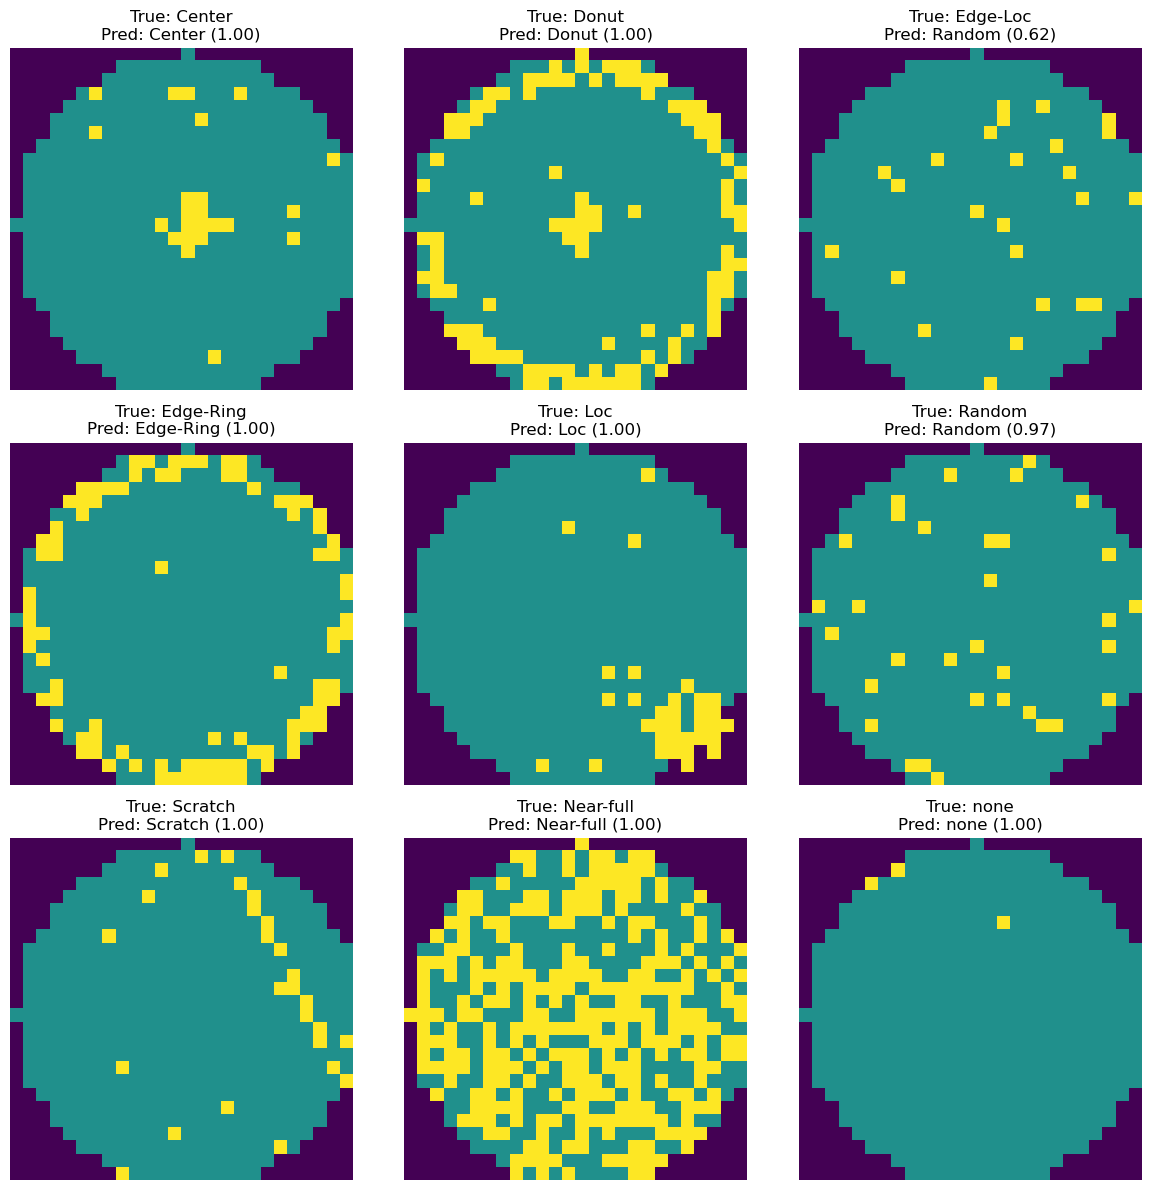

In [15]:
defect_fns=[
    add_center_defect,
    add_donut_defect,
    add_edge_loc_defect,
    add_edge_ring_defect,
    add_loc_defect,
    add_random_defect,
    add_scratch_defect,
    add_near_full_defect,
    add_none_defect
]

defect_names=[
    "Center","Donut","Edge-Loc","Edge-Ring",
    "Loc","Random","Scratch","Near-full","none"
]

fig,ax=plt.subplots(3,3,figsize=(12,12))

for i,(fn,name) in enumerate(zip(defect_fns,defect_names)):
    wafer=fn(create_base_wafer())
    pred,conf=predict_single_wafer(model,wafer)

    r,c=i//3,i%3
    ax[r,c].imshow(wafer,cmap="viridis")
    ax[r,c].set_title(
        f"True: {name}\nPred: {label_mapping[pred]} ({conf:.2f})"
    )
    ax[r,c].axis("off")

plt.tight_layout()
plt.show()


# Testing model on real data

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# model_path="models/synthetic_only_model_100.pth"
# model_path="/kaggle/working/Wafer_defect_classification/synthetic_only_model_200.pth"
model_path="models/synthetic_only_model_200.pth"

In [14]:
num_classes=9

model=WaferCNN(num_classes).to(device)

state_dict=torch.load(model_path,map_location=device)
model.load_state_dict(state_dict)

model.eval()

print("Model loaded successfully")

Model loaded successfully


In [16]:
# df= pd.read_pickle('/content/drive/MyDrive/wafer/LSWMD.pkl')
# df= pd.read_pickle("/kaggle/input/wafer-data/LSWMD.pkl")
df= pd.read_pickle("Dataset/LSWMD.pkl")

In [17]:
df['failureType']=df['failureType'].apply(lambda x:x[0][0] if len(x)>0 else 'none')
df['trianTestLabel']=df['trianTestLabel'].apply(lambda x:x[0][0] if len(x)>0 else 'Unknown')

In [18]:
defect_types=["Center","Donut","Edge-Loc","Edge-Ring","Loc","Random","Scratch","Near-full","none"]

df_labeled=df[df['failureType'].isin(defect_types)]
print("Labeled wafers:",len(df_labeled))

Labeled wafers: 811457


In [19]:
label_mapping={
    "Center":0,
    "Donut":1,
    "Edge-Loc":2,
    "Edge-Ring":3,
    "Loc":4,
    "Random":5,
    "Scratch":6,
    "Near-full":7,
    "none":8
}

df_labeled['label_id']=df_labeled['failureType'].map(label_mapping)


In [20]:
def resize_wafer(wafer):
    return cv2.resize(wafer,(26,26),interpolation=cv2.INTER_NEAREST)

df_labeled['wafer_resized']=df_labeled['waferMap'].apply(resize_wafer)

In [21]:
X_real = np.stack(df_labeled['wafer_resized'].values)
y_real = df_labeled['label_id'].values

X_real = np.eye(3, dtype=np.float32)[X_real]   #(N,26,26,3)
X_real = np.transpose(X_real, (0,3,1,2))       #(N,3,26,26)

print(X_real.shape, y_real.shape)


(811457, 3, 26, 26) (811457,)


In [22]:
_,X_val,_,y_val=train_test_split(X_real,y_real,test_size=0.2,random_state=42,stratify=y_real)


In [23]:
val_ds=TensorDataset(torch.tensor(X_val),torch.tensor(y_val))

val_loader=DataLoader(val_ds,batch_size=128,shuffle=False)


In [24]:
model.eval()

correct=0
total=0

with torch.no_grad():
    for xb,yb in val_loader:
        xb,yb=xb.to(device),yb.to(device)
        out=model(xb)
        preds=torch.argmax(out,dim=1)

        correct+=(preds==yb).sum().item()
        total+=yb.size(0)

acc=correct/total
print(f"Synthetic to Real Accuracy: {acc:.4f}")


Synthetic to Real Accuracy: 0.2246


In [25]:
num_classes=9
class_correct=np.zeros(num_classes)
class_total=np.zeros(num_classes)

with torch.no_grad():
    for xb,yb in val_loader:
        xb,yb=xb.to(device),yb.to(device)
        out=model(xb)
        preds=torch.argmax(out,dim=1)

        for i in range(len(yb)):
            lbl=yb[i].item()
            class_total[lbl]+=1
            if preds[i].item()==lbl:
                class_correct[lbl]+=1

class_acc=class_correct/class_total

inv_label_mapping={v:k for k,v in label_mapping.items()}

for i,acc in enumerate(class_acc):
    print(f"{inv_label_mapping[i]:<10}: {acc:.3f}")


Center    : 0.042
Donut     : 0.000
Edge-Loc  : 0.484
Edge-Ring : 0.581
Loc       : 0.516
Random    : 0.000
Scratch   : 0.046
Near-full : 1.000
none      : 0.219


# Fine tuning

In [26]:
print(device)
model.eval()

cuda


WaferCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [27]:
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.conv2.parameters():
    param.requires_grad = False

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_real,y_real,test_size=0.2,random_state=42,stratify=y_real)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)


(649165, 3, 26, 26) (162292, 3, 26, 26)
(649165,) (162292,)


In [29]:
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),torch.tensor(y_train, dtype=torch.long))

val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32),torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-4)

In [31]:
def finetune(model, loader, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(out, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.4f} | Train Acc: {correct/total:.4f}")


In [32]:
finetune(model, train_loader, optimizer, epochs=18)

Epoch 1/18 | Loss: 0.1552 | Train Acc: 0.9709
Epoch 2/18 | Loss: 0.1129 | Train Acc: 0.9745
Epoch 3/18 | Loss: 0.1036 | Train Acc: 0.9750
Epoch 4/18 | Loss: 0.0978 | Train Acc: 0.9755
Epoch 5/18 | Loss: 0.0938 | Train Acc: 0.9758
Epoch 6/18 | Loss: 0.0907 | Train Acc: 0.9759
Epoch 7/18 | Loss: 0.0883 | Train Acc: 0.9762
Epoch 8/18 | Loss: 0.0863 | Train Acc: 0.9762
Epoch 9/18 | Loss: 0.0845 | Train Acc: 0.9766
Epoch 10/18 | Loss: 0.0830 | Train Acc: 0.9767
Epoch 11/18 | Loss: 0.0818 | Train Acc: 0.9769
Epoch 12/18 | Loss: 0.0807 | Train Acc: 0.9770
Epoch 13/18 | Loss: 0.0797 | Train Acc: 0.9772
Epoch 14/18 | Loss: 0.0789 | Train Acc: 0.9774
Epoch 15/18 | Loss: 0.0780 | Train Acc: 0.9774
Epoch 16/18 | Loss: 0.0772 | Train Acc: 0.9777
Epoch 17/18 | Loss: 0.0766 | Train Acc: 0.9778
Epoch 18/18 | Loss: 0.0759 | Train Acc: 0.9780


In [33]:
for param in model.parameters():
    param.requires_grad = True

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


In [35]:
finetune(model, train_loader, optimizer, epochs=18)

Epoch 1/18 | Loss: 0.0757 | Train Acc: 0.9778
Epoch 2/18 | Loss: 0.0717 | Train Acc: 0.9782
Epoch 3/18 | Loss: 0.0694 | Train Acc: 0.9785
Epoch 4/18 | Loss: 0.0672 | Train Acc: 0.9789
Epoch 5/18 | Loss: 0.0653 | Train Acc: 0.9792
Epoch 6/18 | Loss: 0.0640 | Train Acc: 0.9796
Epoch 7/18 | Loss: 0.0626 | Train Acc: 0.9799
Epoch 8/18 | Loss: 0.0613 | Train Acc: 0.9802
Epoch 9/18 | Loss: 0.0601 | Train Acc: 0.9805
Epoch 10/18 | Loss: 0.0589 | Train Acc: 0.9808
Epoch 11/18 | Loss: 0.0578 | Train Acc: 0.9810
Epoch 12/18 | Loss: 0.0567 | Train Acc: 0.9815
Epoch 13/18 | Loss: 0.0557 | Train Acc: 0.9817
Epoch 14/18 | Loss: 0.0547 | Train Acc: 0.9819
Epoch 15/18 | Loss: 0.0539 | Train Acc: 0.9822
Epoch 16/18 | Loss: 0.0528 | Train Acc: 0.9826
Epoch 17/18 | Loss: 0.0519 | Train Acc: 0.9828
Epoch 18/18 | Loss: 0.0511 | Train Acc: 0.9829


In [36]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)

        correct += (preds == yb).sum().item()
        total += yb.size(0)

acc = correct / total
print(f"Fine-tuned Synthetic → Real Accuracy: {acc:.4f}")


Fine-tuned Synthetic → Real Accuracy: 0.9784


In [37]:
num_classes = 9
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)

        for i in range(len(yb)):
            lbl = yb[i].item()
            class_total[lbl] += 1
            if preds[i].item() == lbl:
                class_correct[lbl] += 1

class_acc = class_correct / class_total

inv_label_mapping = {v: k for k, v in label_mapping.items()}

for i, acc in enumerate(class_acc):
    print(f"{inv_label_mapping[i]:<10}: {acc:.3f}")


Center    : 0.513
Donut     : 0.514
Edge-Loc  : 0.363
Edge-Ring : 0.782
Loc       : 0.335
Random    : 0.249
Scratch   : 0.000
Near-full : 0.067
none      : 0.993


In [38]:
import os
import torch

save_dir="Wafer_defect_classification"
os.makedirs(save_dir,exist_ok=True)

model_path=os.path.join(save_dir,"finetuned_model_200_36.pth")

torch.save(model.state_dict(),model_path)

print("Model saved at:",model_path)


Model saved at: Wafer_defect_classification/finetuned_model_200_36.pth
